# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
import sys
import os
import logging

import optuna

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

sys.path.append("../../src")
sys.path.append("../palm-tree")

import embedder
import models
import utils
import dataset

# Data

We should firstly parse the sample basic block data, or load it from pickle if the parsed data have been saved.
The preprocessing steps are based on data analysis done in the data exploration notebook

In [2]:
data_files = os.listdir("../../dataset/bb_data/")

if "good_dataset.pkl" not in data_files:
    result_files = [f for f in os.listdir("../../../good_dataset/") if f.endswith("results")] 
    #program_data_df = {}
    data_df = pd.DataFrame()

    for file in result_files:
        file_df = utils.read_bb_data(f"../../../good_dataset/{file}/breaker_code.txt", f"../../../good_dataset/{file}/breaker_final_energy.txt")
        file_df = utils.preprocess_bb_df(file_df)
        #program_data_df[file] = file_df
        data_df = pd.concat([data_df, file_df], ignore_index=True)
else:
    data_df = pd.read_pickle("../../dataset/bb_data/good_dataset.pkl")

if "bb_embeddings" not in data_df.columns:
    data_df["bb_embeddings"] = data_df.bb.apply(lambda x: embedder.encode(x))
    data_df.to_pickle("../../dataset/bb_data/good_dataset.pkl")

In [3]:
data_df.head(5)

,bb,energy,bb_embeddings
0,[movl $0x0],0.645165,"[[1.0268462, 0.028481035, 2.7335312, 0.5859081..."
1,"[callq, pushq %rbp, mov %rsp %rbp]",2.910575,"[[0.11681142, -0.7584041, 2.0799158, 0.3227231..."
2,"[popq %rbp, retq]",0.997157,"[[1.0268458, 0.028480439, 2.7335315, 0.5859076..."
3,[movl $0x0],0.664772,"[[1.0268462, 0.028481035, 2.7335312, 0.5859081..."
4,"[cmpl $0x64, jnl 0x2c]",1.400952,"[[1.0268458, 0.028480439, 2.7335315, 0.5859076..."


Pytorch custom dataset

In [23]:
def get_data_dict(
    data_df: pd.DataFrame, split: float = 0.9, mean: bool = False, batch_size: int = 32
) -> dict:

    split = 0.9
    data_df = data_df.sample(frac=1).reset_index(drop=True)
    bb_df_train = data_df[: int(split * len(data_df))]
    bb_df_val = data_df[int(split * len(data_df)) :]

    train_data = dataset.EnergyPredictionDataset(bb_df_train, mean=mean)
    if mean:
        train_loader = DataLoader(
            train_data, batch_size=batch_size, shuffle=False, drop_last=True
        )
    else:
        train_loader = DataLoader(
            train_data,
            batch_size=batch_size,
            shuffle=False,
            drop_last=True,
            collate_fn=utils.collate_fn,
        )

    val_data = dataset.EnergyPredictionDataset(bb_df_val, mean=mean)
    if mean:
        val_loader = DataLoader(
            val_data, batch_size=batch_size, shuffle=False, drop_last=True
        )
    else:
        val_loader = DataLoader(
            val_data,
            batch_size=batch_size,
            shuffle=False,
            drop_last=True,
            collate_fn=utils.collate_fn,
        )

    data_loaders = {
        "train_df": bb_df_train,
        "val_df": bb_df_val,
        "train_loader": train_loader,
        "val_loader": val_loader,
    }

    return data_loaders

# LSTM Model

In [5]:
class LSTM_Regressor(nn.Module):
    def __init__(
        self,
        emb_size: int,
        hidden_size: int = 16,
        num_layers: int = 2,
        bidirectional: bool = False,
        dense_size: int = 128,
    ) -> None:
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        if self.num_layers > 1:
            lstm_dropout = 0.1
        else:
            lstm_dropout = 0

        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=lstm_dropout,
        )

        self.dense = nn.Linear(hidden_size, dense_size)
        self.dropout = nn.Dropout(0.1)
        self.smaller_dense = nn.Linear(dense_size, 16)
        self.regressor = nn.Linear(16, 1)

    def forward(self, x, hidden):

        batch_size = x.size(0)

        lstm_out, hidden_state = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)

        out = self.dense(lstm_out)
        out = self.dropout(out)
        out = self.smaller_dense(out)
        out = self.regressor(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]

        return out, hidden_state

    def init_hidden(self, batch_size):

        hidden = (
            torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda(),
            torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda(),
        )

        return hidden


# Training Functions

In [6]:
class EarlyStopper:
    def __init__(self, patience: int = 15, min_delta: float = 1e-3):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss: float):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
EPOCHS = 100

def train_lstm_model(
    model: LSTM_Regressor,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float = 1e-2,
    batch_size: int = 32,
    epochs: int = 100,
    verbose: bool = False,
    early_stopping: bool = True,
) -> dict:

    if early_stopping:
        early_stopper = EarlyStopper(patience=20, min_delta=0.05)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=1e-4)

    model.cuda()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        hidden_state = model.init_hidden(batch_size=batch_size)
        losses = []
        for embeddings, _, labels in train_loader:

            embeddings = embeddings.cuda()
            labels = labels.cuda()

            hidden_state = tuple([each.data for each in hidden_state])

            output, hidden_state = model(embeddings, hidden_state)
            loss = criterion(output.squeeze(), labels.float())

            optimizer.zero_grad()
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            losses.append(loss.item())

        val_h = model.init_hidden(batch_size)
        val_loss = []
        model.eval()
        for embeddings, _, labels in val_loader:

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history

            embeddings, labels = embeddings.cuda(), labels.cuda()
            output, val_h = model(embeddings, val_h)
            v_loss = criterion(output.squeeze(), labels.float())

            val_loss.append(v_loss.item())

        if verbose:
            print(
                f"Epoch: {epoch+1}/{EPOCHS}, MSE Train Loss: {round(np.mean(losses), 5)}, MSE Val Loss: {round(np.mean(val_loss), 5)}"
            )

        train_losses.append(np.mean(losses))
        val_losses.append(np.mean(val_loss))

        if early_stopping:
            early_stopper.early_stop(val_losses[-1])

    model_training = {
        "model": model,
        "train_loss": train_losses,
        "val_loss": val_losses,
        "epochs_trained": epochs,
    }

    return model_training


## Optuna Trials

In [8]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "lstm-regression-study-good-dataset"
storage_name = f"sqlite:////Users/thodo/Documents/σχολη/diplomatiki/optuna-studies/{study_name}.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")

[I 2023-01-07 15:04:40,553] Using an existing study with name 'lstm-regression-study-good-dataset' instead of creating a new one.


Using an existing study with name 'lstm-regression-study-good-dataset' instead of creating a new one.


In [ ]:
def objective(trial):

    lstm_layers = trial.suggest_int("lstm_layers", 1, 5)
    hidden_size = trial.suggest_int("hidden_size", 8, 128)
    bidirectional = trial.suggest_categorical("bidirectional", [True, False])
    dense_size = trial.suggest_int("dense_size", 16, 256)
    batch_size_exp = trial.suggest_int("batch_size_exp", 3, 7)
    lr_exp = trial.suggest_int("learning_rate_exp", -4, -2)

    batch_size = 2**batch_size_exp
    lr = 10**lr_exp

    data_loaders = get_data_dict(data_df=data_df, mean=False, batch_size=batch_size)
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    emb_size = next(iter(train_loader))[0].shape[-1]

    model = LSTM_Regressor(
        emb_size=emb_size, hidden_size=hidden_size, num_layers=lstm_layers, bidirectional=bidirectional, dense_size=dense_size
    )
    train_results = train_lstm_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        batch_size=batch_size,
        early_stopping=True,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]


study.optimize(objective, n_trials=100)

In [9]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_batch_size_exp,params_bidirectional,params_dense_size,params_hidden_size,params_learning_rate_exp,params_lstm_layers,state
0,0,0.368719,2023-01-06 19:52:59.402795,2023-01-06 20:01:02.966292,0 days 00:08:03.563497,6,False,115,93,-3,3,COMPLETE
1,1,0.385264,2023-01-06 20:01:02.997791,2023-01-06 20:11:16.885792,0 days 00:10:13.888001,5,True,100,106,-3,1,COMPLETE
2,2,0.454018,2023-01-06 20:11:16.915293,2023-01-06 20:26:04.671792,0 days 00:14:47.756499,5,True,63,60,-3,3,COMPLETE
3,3,1.443266,2023-01-06 20:26:04.697332,2023-01-06 21:00:11.220793,0 days 00:34:06.523461,4,False,203,101,-2,4,COMPLETE
4,4,0.390236,2023-01-06 21:00:11.248792,2023-01-06 21:10:14.366905,0 days 00:10:03.118113,5,True,34,71,-3,1,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.413680,2023-01-07 11:43:28.405715,2023-01-07 11:49:57.354716,0 days 00:06:28.949001,6,False,242,106,-4,2,COMPLETE
96,96,0.361657,2023-01-07 11:49:57.379713,2023-01-07 11:55:24.239214,0 days 00:05:26.859501,6,True,251,26,-4,1,COMPLETE
97,97,0.369636,2023-01-07 11:55:24.264714,2023-01-07 12:09:55.985119,0 days 00:14:31.720405,5,False,84,42,-4,3,COMPLETE
98,98,0.358976,2023-01-07 12:09:56.015119,2023-01-07 12:16:27.782118,0 days 00:06:31.766999,6,False,232,16,-4,2,COMPLETE


In [13]:
print(f"Best lstm-regressor-model params: {study.best_params}, achieving val MSE: {study.best_value}")

Best lstm-regressor-model params: {'batch_size_exp': 6, 'bidirectional': False, 'dense_size': 110, 'hidden_size': 18, 'learning_rate_exp': -4, 'lstm_layers': 4}, achieving val MSE: 0.349718384882983


## Results

In [16]:
data_loaders = get_data_dict(data_df=data_df, mean=False, batch_size=128)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

emb_size = next(iter(train_loader))[0].shape[-1]

model = LSTM_Regressor(
    emb_size=emb_size, hidden_size=18, num_layers=4
)
train_results = train_lstm_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=1e-4,
    epochs=200,
    batch_size=128,
    verbose=True,
    early_stopping=True,
)

Epoch: 1/100, MSE Train Loss: 0.96277, MSE Val Loss: 0.90922
Epoch: 2/100, MSE Train Loss: 0.75697, MSE Val Loss: 0.66717
Epoch: 3/100, MSE Train Loss: 0.58175, MSE Val Loss: 0.55729
Epoch: 4/100, MSE Train Loss: 0.4796, MSE Val Loss: 0.46486
Epoch: 5/100, MSE Train Loss: 0.41196, MSE Val Loss: 0.4045
Epoch: 6/100, MSE Train Loss: 0.35723, MSE Val Loss: 0.37749
Epoch: 7/100, MSE Train Loss: 0.33154, MSE Val Loss: 0.37432
Epoch: 8/100, MSE Train Loss: 0.32464, MSE Val Loss: 0.37542
Epoch: 9/100, MSE Train Loss: 0.3174, MSE Val Loss: 0.37465
Epoch: 10/100, MSE Train Loss: 0.31164, MSE Val Loss: 0.37453
Epoch: 11/100, MSE Train Loss: 0.31118, MSE Val Loss: 0.37326
Epoch: 12/100, MSE Train Loss: 0.3115, MSE Val Loss: 0.37234
Epoch: 13/100, MSE Train Loss: 0.3034, MSE Val Loss: 0.36959
Epoch: 14/100, MSE Train Loss: 0.30203, MSE Val Loss: 0.36891
Epoch: 15/100, MSE Train Loss: 0.30169, MSE Val Loss: 0.36811
Epoch: 16/100, MSE Train Loss: 0.29899, MSE Val Loss: 0.36609
Epoch: 17/100, MSE Tra

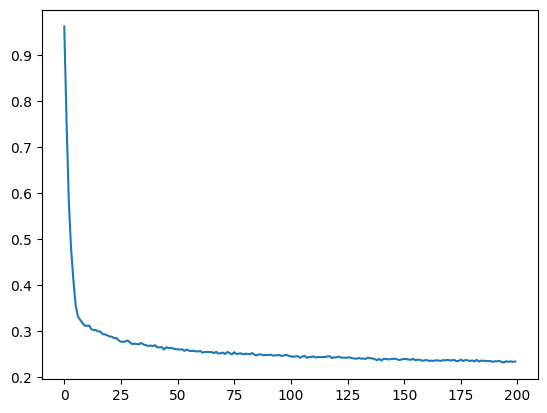

In [17]:
plt.plot(train_results["train_loss"])
plt.show()

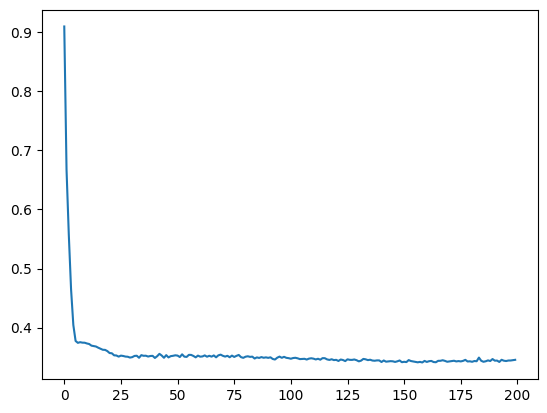

In [18]:
plt.plot(train_results["val_loss"])
plt.show()

In [19]:
preds = []
true_energies = []

val_h = model.init_hidden(128)
for embeddings, _, labels in val_loader:

    embeddings, labels = embeddings.cuda(), labels.cuda()  
    output, val_h = model(embeddings, val_h)
    preds.append(output.tolist())
    true_energies.append(labels.tolist())

preds = np.array(preds).flatten()
true_energies = np.array(true_energies).flatten()

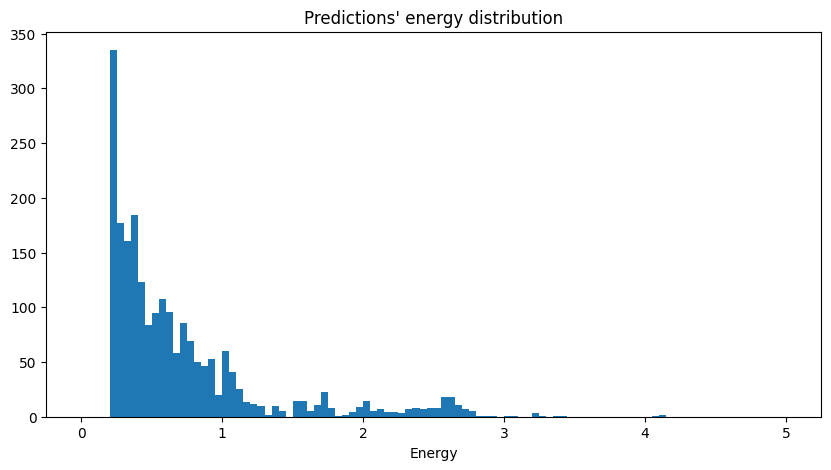

In [20]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

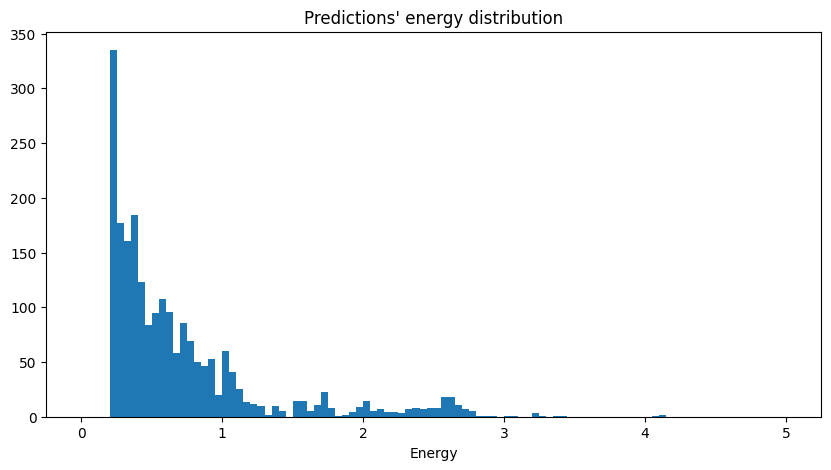

In [21]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

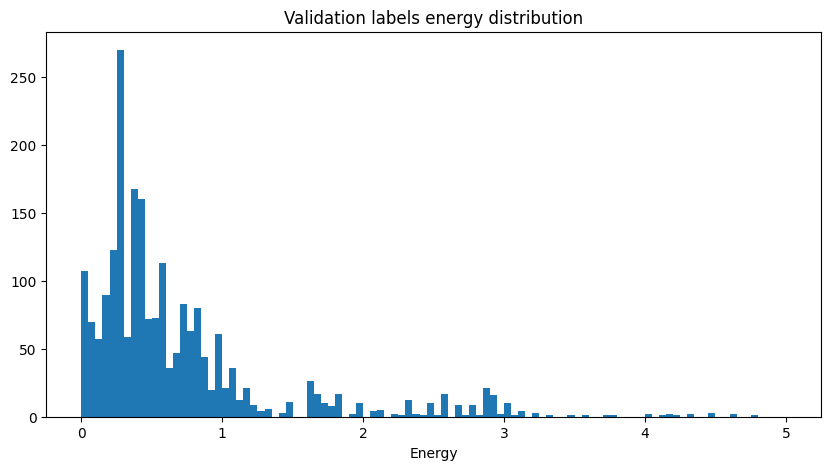

In [24]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [25]:
median = np.median(true_energies)
std = np.std(true_energies)

print(f"Labels' median: {median}, Labels' std: {std}")

Labels' median: 0.4437827194929485, Labels' std: 0.9621791555048604


# Simple Model

In [7]:
class Simple_Regressor(nn.Module):

    def __init__(self, emb_size: int) -> None:
        super().__init__()

        self.dense = nn.Linear(emb_size, 256)
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128, 64)
        self.dense4 = nn.Linear(64, 16)
        self.dense5 = nn.Linear(16, 4)
        self.dropout = nn.Dropout(0.15)
        self.dropout2 = nn.Dropout(0.05)
        self.regressor = nn.Linear(4, 1)

    def forward(self, x):
        
        out = self.dense(x)
        out = self.dropout(out)
        out = self.dense2(out)
        out = self.dropout(out)
        out = self.dense3(out)
        out = self.dropout(out)
        out = self.dense4(out)
        out = self.dropout2(out)
        out = self.dense5(out)
        out = self.regressor(out)

        return out

In [8]:
EMBEDDING_DIM = train_data.__getitem__(0)[0].shape[0]

model = Simple_Regressor(emb_size=EMBEDDING_DIM)
print(model)

Simple_Regressor(
  (dense): Linear(in_features=128, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=64, bias=True)
  (dense4): Linear(in_features=64, out_features=16, bias=True)
  (dense5): Linear(in_features=16, out_features=4, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (dropout2): Dropout(p=0.05, inplace=False)
  (regressor): Linear(in_features=4, out_features=1, bias=True)
)


In [9]:
EPOCHS = 500

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-4)

model.cuda()
model.train()

#cnt = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    losses = []
    for embeddings, labels in train_loader:
        #cnt += 1

        embeddings = embeddings.cuda()
        labels = labels.cuda()

        output = model(embeddings)
        loss = criterion(output.squeeze(), labels.float())

        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        
        losses.append(round(loss.item(), 2))

    #if cnt % 100 == 0:

    val_loss = []
    model.eval()
    for embeddings, labels in val_loader:

        embeddings, labels = embeddings.cuda(), labels.cuda()  
        output = model(embeddings)
        v_loss = criterion(output.squeeze(), labels.float())

        val_loss.append(v_loss.item())

    model.train()
    print(
        f"Epoch: {epoch+1}/{EPOCHS}, MSE Train Loss: {np.mean(losses)}, MSE Val Loss: {np.mean(val_loss)}"
    )

    train_losses.append(np.mean(losses))
    val_losses.append(np.mean(val_loss))

Epoch: 1/500, MSE Train Loss: 0.7369426751592357, MSE Val Loss: 0.6702087207332902
Epoch: 2/500, MSE Train Loss: 0.634235668789809, MSE Val Loss: 0.6491751534783322
Epoch: 3/500, MSE Train Loss: 0.6037579617834395, MSE Val Loss: 0.6472167122191277
Epoch: 4/500, MSE Train Loss: 0.5838057324840764, MSE Val Loss: 0.623615113073501
Epoch: 5/500, MSE Train Loss: 0.5763535031847133, MSE Val Loss: 0.6140937173496122
Epoch: 6/500, MSE Train Loss: 0.5640605095541401, MSE Val Loss: 0.6276457506245461
Epoch: 7/500, MSE Train Loss: 0.5549363057324841, MSE Val Loss: 0.601125465463037
Epoch: 8/500, MSE Train Loss: 0.5518630573248408, MSE Val Loss: 0.6041701390691425
Epoch: 9/500, MSE Train Loss: 0.5463216560509554, MSE Val Loss: 0.5923479851605236
Epoch: 10/500, MSE Train Loss: 0.5423089171974522, MSE Val Loss: 0.6038259403861087
Epoch: 11/500, MSE Train Loss: 0.5410350318471338, MSE Val Loss: 0.6086318131158317
Epoch: 12/500, MSE Train Loss: 0.5309076433121018, MSE Val Loss: 0.5930093595947045
Epoc

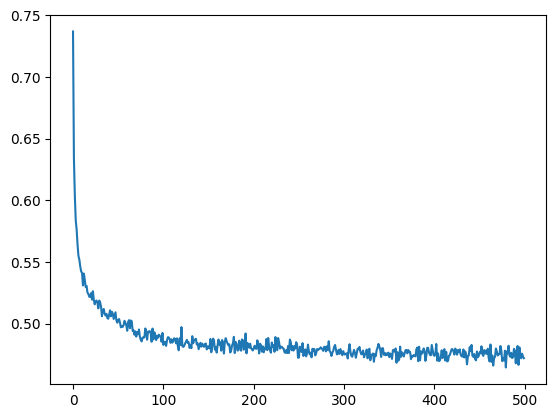

In [10]:
plt.plot(train_losses)
plt.show()

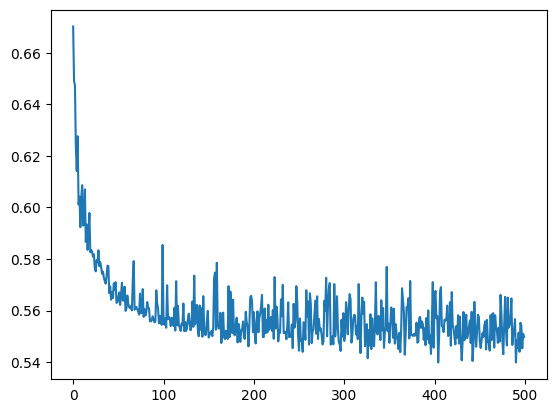

In [11]:
plt.plot(val_losses)
plt.show()

In [14]:
preds = []

for embeddings, labels in val_loader:
    embeddings, labels = embeddings.cuda(), labels.cuda()  
    preds.append(model(embeddings).tolist())

preds = np.array(preds).flatten()

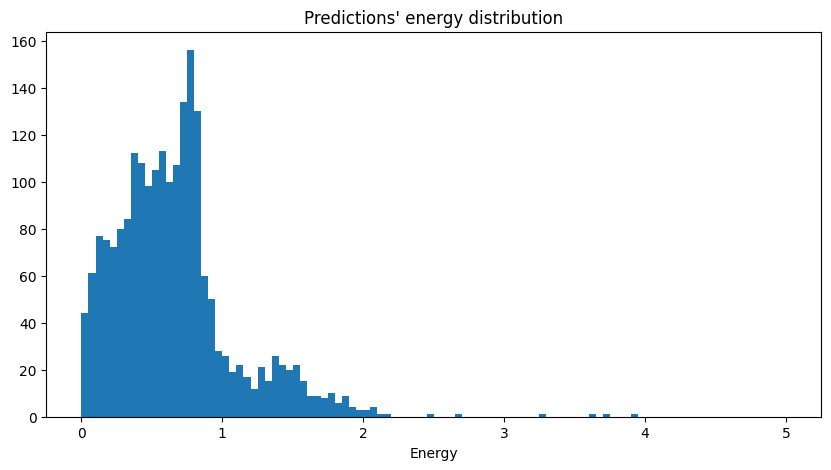

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

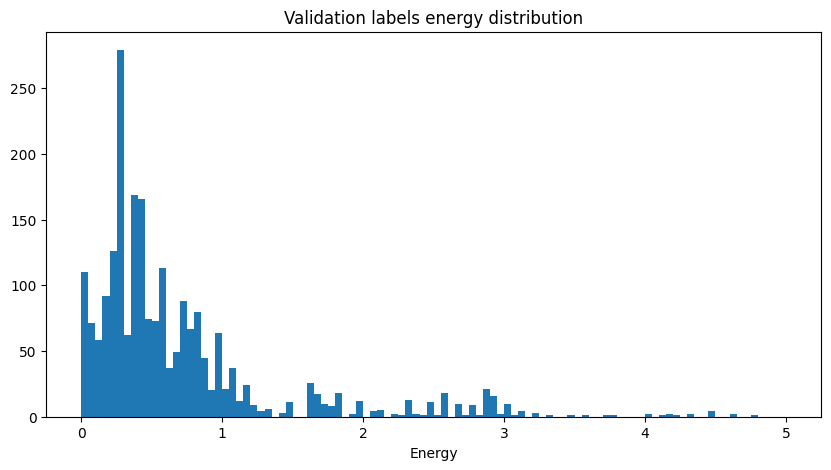

In [16]:
val_labels = bb_df_val.energy

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()